<a href="https://colab.research.google.com/github/RichZhou1999/CE263-EV-Adoption-Diffusion-Model-/blob/main/%E2%80%9CHW1%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/main/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Featurized Models for Sentiment Analysis

For this assignment, we provide an implementation of a simple binary classifier that will predict the sentiment of a movie review based on a group of original features -- provided by you! 

Before diving into any code, please read through the associated [PDF](https://github.com/dbamman/nlp23/blob/main/HW1/HW1.pdf) for an overview of the assignment and specific instructions on how to submit.

In [ ]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Intro: Gather Data + Create Classifier

#### Gather Data

Let's download the data we'll use for training and development, and also the data we'll make predictions with.

In [ ]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/test.txt

--2023-01-27 03:25:57--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt.1’

train.txt.1         100%[===================>]   1.26M  --.-KB/s    in 0.03s   

2023-01-27 03:25:58 (38.3 MB/s) - ‘train.txt.1’ saved [1322055/1322055]

--2023-01-27 03:25:58--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt.1’

In [ ]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

#### Define Classifier class

Next, we've created a Binary Classifier. This class will let us learn the traits associated with positive and negatively classed movie reviews in order to make predictions on our test set.

In [ ]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

#### Simple Classifier example

Let's create an initial classifier based on a really simple feature using a dictionary: 

* if the abstract contains the words "love" or "like", the `contains_positive_word` feature will fire, and 
* if it contains either "hate" or "dislike", the `contains_negative_word` will fire.  

Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words (the documentation for which can be found [here](https://www.nltk.org/api/nltk.tokenize.html)).

In [ ]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data. 

Note the `L2_regularization_strength` parameter specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and `min_feature_count` specifies how many data points need to contain a feature for it to be passed into the model as a feature. Both are ways to prevent the model from overfitting and achieve higher performance.

In [ ]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

So we've created a classifier. But is its accuracy score any good?  Let's calculate the accuracy of a "majority classifier" to provide some context. This determines the most-represented (majority) class in the training data, and then predicts every test point to be this class.

In [ ]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

The feature we created in `simple_featurize`, evidently, doesn't have a whole lot of legs. In the next portion of the homework, you'll be designing a few features of your own in the hopes of achieving the highest accuracy possible.

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm **3 additional** distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data.

To show your work: describe your new features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words||
|Feature 1||
|Feature 2||
|Feature 3||

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment. Consider the type of data you are working with: what do you look for when writing/reading a movie review?

### Implement Bag-of-Words

In [ ]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    # BEGIN SOLUTION
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
        word=word.lower()
        if word not in feats:
          feats[word] = 1
        else:
          feats[word] += 1
    return feats
    # END SOLUTION

In [ ]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

### Implement Original Features

In [ ]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)
    for i in range(1,len(words)):
        word1= words[i-1]
        word2 = words[i]
        if word1+word2 not in feats:
          feats[word1+word2] = 1
    return feats
               

In [ ]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 127848, Train accuracy: 1.000, Dev accuracy: 0.754


In [ ]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    feats["test"]=1
            
    return feats

In [ ]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

In [ ]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    feats["test"]=1
            
    return feats

In [ ]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

## Deliverable 2

The two cells in "Combine your features" will generate a file named `combiner_function_predictions.csv`.

Download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 students with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

Please do not change the auto-generated filename!

### Combine your features

Next, let's combine any or all the features you have developed into one big model and make predictions on the test data. There is no exact number/threshold we're looking for, accuracy-wise, but the combiner function should *generally* have a higher accuracy than BoW on its own (assuming your features are adding additional information beyond what BoW is adding). 

You don't need to edit the following cell, unless you want to change which features are handed off to the "combined" model.

In [ ]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    # at the moment, all 4 of: bag of words and your 3 original features are handed off to the combined model
    # update the values within [bag_of_words, feature1, feature2, feature3] to change this.
    
    all_feats={}
    for feature in [bag_of_words, feature1, feature2, feature3]:
        all_feats.update(feature(text))
    return all_feats

In [ ]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 148656, Train accuracy: 1.000, Dev accuracy: 0.773


## Further Exploration: Interrogating classifiers

Note: No deliverables are in this section; it's optional. Treat this portion as a useful tool for further understanding the features you worked on and how they affter the classifier.

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels). What kinds of mistakes is it making? (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


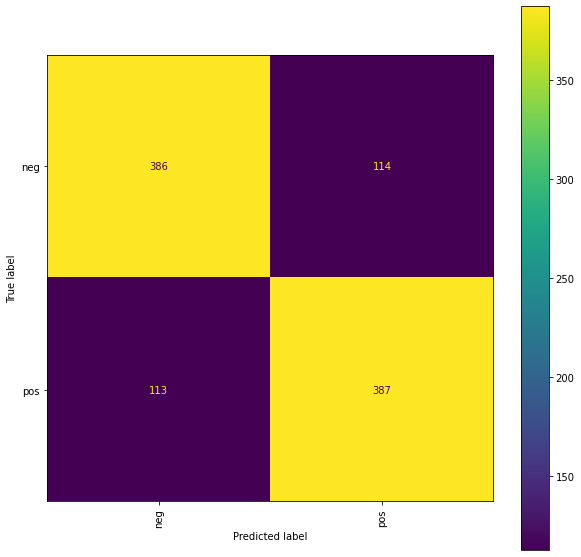

In [ ]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most important for each of the classes (ranked by how strong their corresponding coefficient is). Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [ ]:
big_classifier.printWeights(n=25)

pos	0.616	great
pos	0.389	excellent
pos	0.365	series
pos	0.358	best
pos	0.346	.It
pos	0.343	amazing
pos	0.330	man
pos	0.310	you
pos	0.296	story
pos	0.278	my
pos	0.274	will
pos	0.268	enjoyed
pos	0.266	very
pos	0.265	it
pos	0.262	performance
pos	0.253	isa
pos	0.250	fun
pos	0.249	atthe
pos	0.244	also
pos	0.244	relationship
pos	0.241	perfect
pos	0.233	thought
pos	0.230	love
pos	0.229	and
pos	0.226	him

neg	-0.515	worst
neg	-0.494	even
neg	-0.475	bad
neg	-0.461	no
neg	-0.455	would
neg	-0.452	boring
neg	-0.444	acting
neg	-0.423	stupid
neg	-0.403	there
neg	-0.390	could
neg	-0.375	,I
neg	-0.352	idea
neg	-0.350	theworst
neg	-0.336	nothing
neg	-0.331	horrible
neg	-0.326	?
neg	-0.301	waste
neg	-0.298	actors
neg	-0.296	instead
neg	-0.281	just
neg	-0.276	had
neg	-0.267	watching
neg	-0.267	poor
neg	-0.260	do
neg	-0.256	than



3. Next, let's look at the individual data points that are the hardest to classify correctly. Does it suggest any features you might create to disentangle them?

In [ ]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [ ]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1787,0.999984,pos,neg,"My roommate had bought this documentary and invited me to watch it with her. She's from China and only heard so much about 9/11 and wanted to know the cold hard truth and she wanted me to tell her more after the documentary. I felt awful watching this documentary, it was like reliving the nightmare and it still brings tears to my eyes.But I'm extremely grateful that I watched this documentary,..."
1,1138,0.999957,pos,neg,"I find it so amazing that even after all these years, we are STILL talking about this movie! Obviously this movie wasn't THAT bad or else people wouldn't even BOTHER to talk about it. I personally enjoyed this film immensly, and still do! I guess this film isn't for everyone, but it certainly did touch the hearts of many. As for those that think that this film is ""overrated"" or ""over-hyped""......"
2,1178,0.999952,pos,neg,"While I do not think this was a perfect 10, I do agree it was way above a 6 which is what it's rated here. No, Brokedown Palace was not perfect and yes it's plot has been done many times before. That doesn't mean it shouldn't be done again if it is done well and I think this movie had some strong moments. The acting of Claire Danes, as already mentioned many times, was flawless as was Kate Bec..."
3,1261,0.999949,neg,pos,"NATURAL BORN KILLERS (1994)Cinema Cut: R Director's Cut: NC-17It's an unusual Oliver Stone picture, but when I read he was on drugs during the filming, I needed no further explanation. 'Natural Born Killers' is a risky, mad, all out film-making that we do not get very often; strange, psychotic, artistic pictures.'Natural Born Killers' is basically the story of how two mass killers were popular..."
4,1608,0.999925,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling""is an everyday story of royal folk in late nineteenth century Austria.Set during one of Europe's seemingly incessant internal turmoils it concerns itself with the Emperor Franz Joseph (Mr James Mason),his rebellious son,the Crown Prince Rudolf (Mr Omar Sharif)the Empress(Miss Ava Gardner) and various mistresses,secret ..."
5,1508,0.999717,pos,neg,"Gruveyman2 (comment below)you are a complete idiot...blinded by ignorance by the very city you have allegiance to. Its that whiny arrogance, that you are ironically claiming the film exudes about SF, that makes you seem like such the typical LA A**hole! The only reason you felt the film was so self congratulatory about SF is because you are jealous. Of course you don't know it because you are ..."
6,1931,0.999554,pos,neg,"She's not Michael JordanThink of all the marvelous NBA players whose career light has been dimmed for no other good reason than the timing of their birth. Their names might trip as easily off the public's lips as Russell, Cousy, Byrd, Magic, McHale, Oscar, Wilt, the list goes on; but the volume gets turned down a little, for Stockton and Malone, Charles, Patrick and all the other great players..."
7,1436,0.999428,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
8,1663,0.998995,pos,neg,"It sounds as if it should be a biography of Claude Monet but it's actually a highly focused story of relationships between three adolescent girls on a French synchronized swimming team. There are no parents or teachers to speak of, no school, and boys are represented by one peripheral figure, the hunky Francois who enters the story determined from time to time and always leaves confused.Paulin..."
9,1979,0.997972,pos,neg,"When you start watching this animation-masterpiece, you quickly notice, tha